# XGBoost

## Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import pickle


# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Files
from util import fetchOnlineData, create_dataset
from indicators import get_indicators

# TA Library (https://github.com/bukosabino/ta)
from ta import *

sns.set(font_scale = 1.5)

## Initial variables

In [2]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(1000)

# Compute indicators from TA library

## Import dataset

In [3]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [4]:
df = add_all_ta_features(portf_value, "Open", "High", "Low", "Close", "Volume", fillna=True)

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:634: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ta/trend.py:656: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



## Changing index and columns

In [5]:
# Delete unuseful columns
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Volume']

# Create 'date' column for posterior index
df['date'] = df.index

# Rename column for correlation matrix. Can't have spaces.
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Reset index
df.reset_index(inplace=True)

## Correlation matrix

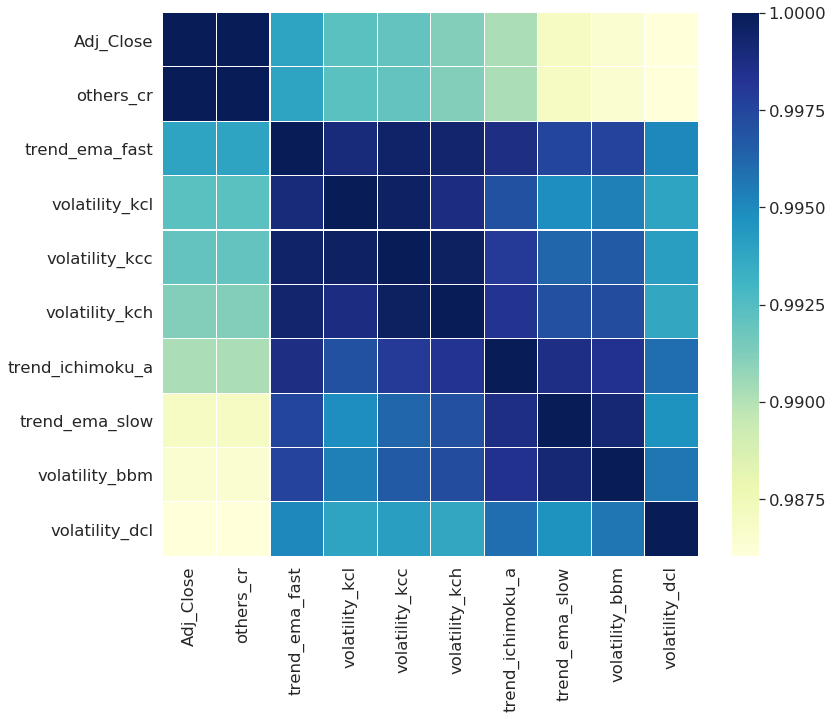

In [6]:
# Adj Close correlation matrix
corrmat = df.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Adj_Close')['Adj_Close'].index
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize =(12, 10)) 
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 
plt.show()

## Indicators to use

* others_cr: Cumulative Return.
* trend_ema_fast: Fast Exponential Moving Averages (EMA) 
* volatility_kcl: Keltner Channel

### Create a dataframe with indicators to use

In [7]:
dataset = df[['Adj_Close', 'others_cr', 'trend_ema_fast', 'volatility_kcl']].copy()

## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [8]:
# Scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
np_scaled = scaler.fit_transform(dataset)
dataset_normalized = pd.DataFrame(np_scaled)

## Setup the Target variable or the desired output.

In [9]:
X, y = dataset_normalized.iloc[:,:-1], dataset_normalized.iloc[:,-1]

## Create XGBoost DMatrix structure

In [39]:
feature_names = ['others_cr', 'trend_ema_fast', 'volatility_kcl']
data_dmatrix = xgb.DMatrix(data=X,label=y, feature_names=feature_names)

## Optimize parameters

In [40]:
print("Parameter optimization")

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200],
                    'learning_rate': [0.01, 0.1, 0.5],
                    'min_samples_split':range(200,1001,2000)}, verbose=1)
clf.fit(X,y)
print('Best Score: ', clf.best_score_)
print('Best params: ', clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Score:  -0.5334436469517009
Best params:  {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 200, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    4.6s finished


## Create a hyper-parameter dictionary

We will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

In [41]:
params = {'silent':1,
          "objective":"reg:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 4,
          'alpha': 10,
          'min_samples_split': 200,
          'n_estimators': 100}

We will use these parameters to build a x-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [42]:
cv_results = xgb.cv(verbose_eval=False,
                    dtrain=data_dmatrix, 
                    params=params, 
                    nfold=10,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123,)

XGBoostError: b'[22:09:50] /workspace/src/objective/regression_obj.cu:102: label must be in [0,1] for logistic regression\n\nStack trace returned 10 entries:\n[bt] (0) /home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::StackTrace()+0x3d) [0x7fa8144395cd]\n[bt] (1) /home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x18) [0x7fa8144399c8]\n[bt] (2) /home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticRegression>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0xa09) [0x7fa8146330a9]\n[bt] (3) /home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x362) [0x7fa8144b01e2]\n[bt] (4) /home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x35) [0x7fa814431ab5]\n[bt] (5) /home/emi/miniconda3/envs/factors/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fa8494f3ec0]\n[bt] (6) /home/emi/miniconda3/envs/factors/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fa8494f387d]\n[bt] (7) /home/emi/miniconda3/envs/factors/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fa849710ede]\n[bt] (8) /home/emi/miniconda3/envs/factors/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x13915) [0x7fa849711915]\n[bt] (9) /home/emi/miniconda3/envs/factors/bin/python(_PyObject_FastCallDict+0x8b) [0x5653b594d92b]\n\n'

## cv_results contains train and test RMSE metrics for each boosting round.

In [14]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.281086,0.001424,0.280853,0.014026
1,0.259767,0.001320,0.259508,0.013636
2,0.240782,0.001185,0.240598,0.013357
3,0.223645,0.001092,0.223520,0.013016
4,0.208332,0.000999,0.208232,0.012861


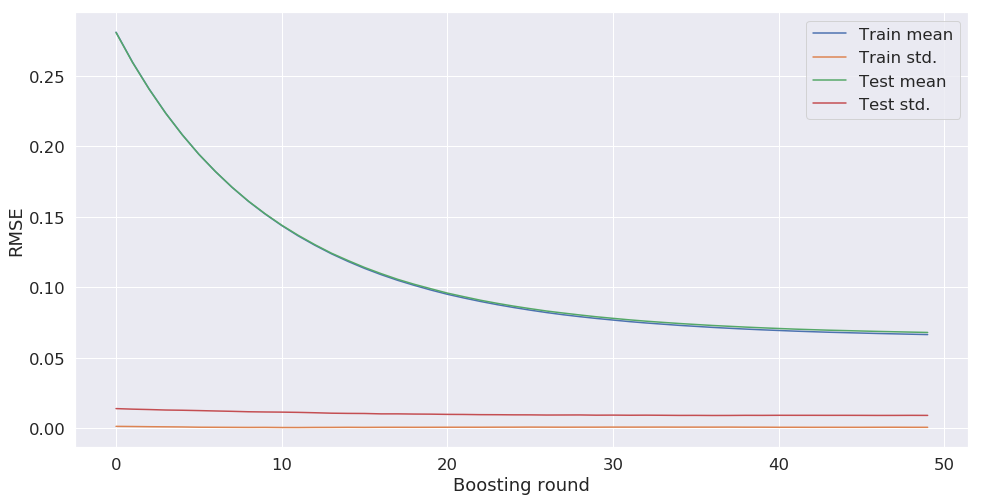

In [15]:
plt.figure(figsize=(16,8))
plt.plot(cv_results)
plt.xlabel('Boosting round')
plt.ylabel("RMSE")
plt.legend(["Train mean", "Train std.", "Test mean", "Test std."])
plt.show()

## Extract and print the final boosting round metric.

In [16]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.068039
Name: test-rmse-mean, dtype: float64


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be lower. 

You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters. 

## Instantiate an XGBoost regressor object

In [17]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

## Plotting the first tree

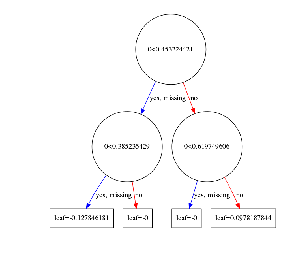

In [18]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [18, 6]
plt.show()

## Visualize your XGBoost models

It's to examine the importance of each feature column in the original dataset within the model.

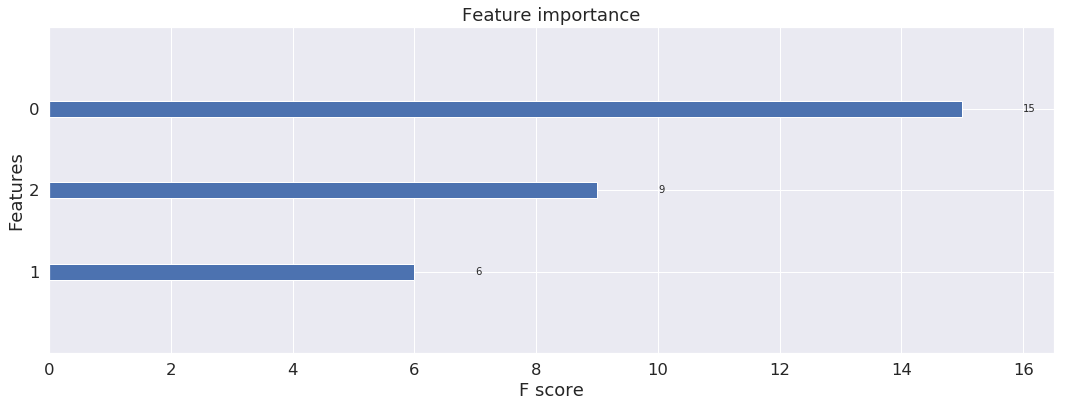

In [19]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [18, 6]
plt.show()

## Instantiate an XGBoost regressor object

## Split the data

In [20]:
# Define X and y
feature_cols = ['others_cr', 'trend_ema_fast', 'volatility_kcl']
X = dataset[feature_cols]
y = dataset['Adj_Close']

In [21]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [22]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))

In [23]:
xg_reg = xgb.XGBRegressor(**params)

## Fit the regressor to the training set

In [24]:
xg_reg.fit(X_train_scaled,y_train_scaled, eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],)

[0]	validation_0-rmse:0.280991	validation_1-rmse:0.223318
[1]	validation_0-rmse:0.254708	validation_1-rmse:0.203285
[2]	validation_0-rmse:0.231065	validation_1-rmse:0.184731
[3]	validation_0-rmse:0.209744	validation_1-rmse:0.168066
[4]	validation_0-rmse:0.190607	validation_1-rmse:0.153312
[5]	validation_0-rmse:0.17321	validation_1-rmse:0.139686
[6]	validation_0-rmse:0.157621	validation_1-rmse:0.128181
[7]	validation_0-rmse:0.143527	validation_1-rmse:0.117698
[8]	validation_0-rmse:0.13078	validation_1-rmse:0.108597
[9]	validation_0-rmse:0.119285	validation_1-rmse:0.100271
[10]	validation_0-rmse:0.108657	validation_1-rmse:0.091867
[11]	validation_0-rmse:0.099029	validation_1-rmse:0.08425
[12]	validation_0-rmse:0.090307	validation_1-rmse:0.077405
[13]	validation_0-rmse:0.082399	validation_1-rmse:0.071156
[14]	validation_0-rmse:0.075448	validation_1-rmse:0.066611
[15]	validation_0-rmse:0.069194	validation_1-rmse:0.062697
[16]	validation_0-rmse:0.063549	validation_1-rmse:0.059293
[17]	valid

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, min_samples_split=200,
       missing=None, n_estimators=100, n_jobs=1, nthread=None,
       objective='reg:logistic', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=1, subsample=1)

## Make predictions on the test set

In [25]:
preds = xg_reg.predict(X_test_scaled)

## Compute the rmse

In [26]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.034858


## Plotting

### Standarize data 

In [27]:
preds = scaler.inverse_transform([preds])


In [28]:
# Convert array to series
mylist = preds.tolist()
se = pd.Series(mylist)


In [29]:
# Create a dataframe for plotting
predictions = pd.DataFrame()
predictions['Price'] = y_test
predictions['Forecast'] = se[0]

# Create dates df index
df1 = df['date'].tail(len(y_test))

# Concatenate both dataframes
pred = pd.concat([predictions, df1], axis=1)

# Set index
pred.set_index('date', inplace=True)


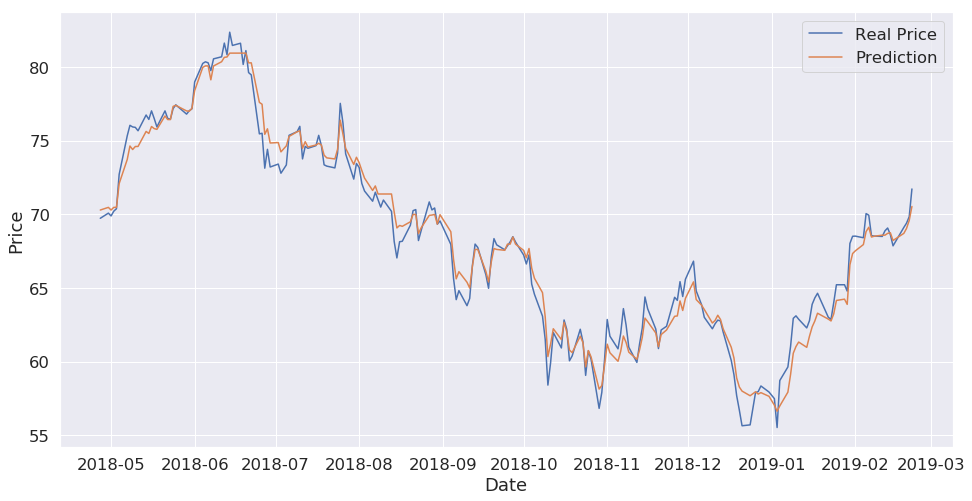

In [30]:
plt.figure(figsize=(16,8))
plt.plot(pred)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

# Save model

In [31]:
# save model to file
#joblib.dump(model, "./xgboost.dat")
# The sklearn API models are picklable
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xg_reg, open("./xgboost.pkl", "wb"))

Pickling sklearn API models
